# Pump it up challenge!

## Background

Using data from Taarifa and the Tanzanian Ministry of Water, try to predict which pumps are functional, which need some repairs, and which don't work at all.

An understanding of which pumps are failing can improve the accessibility of communities to clean water. Furthermore, if pumps are broken or faulty, less time will be spent reporting them and waiting for repairs. 

## Data

The input data are csv files containing a training set, test set and labels for both. Information about each pump is given related to:

- Installation data
- Location
- Height
- Population 
- Extraction type
- Management
- Payment
- Water quality
- Source
- Water point type

## Plan

- The model strategy:
    - Supervised
    - Classification
    - Batch learning
    - Performance measure should be precision/recall/F1.
    
- Assumptions:
    - Use:
        - Given the same information as in the training set.
    - Subjective categories like "water_quality", "quantity" etc are correct.
    - Functional need repair label could be a broad range of functionality.

## Goals

### Personal

- This notebook is really to familiarise myself with datascience preprocessing tools and classification models using python. I have read the theory for many of the tools and machine learning techniques but want to get my teeth into an actual project.

### Project related

- Want a high recall for the broken pumps and the faulty but still functioning pumps. 
- Maybe have a recall of $>90\%$ with a precision of $>80\%$?
- If we can gain inferences about what features are useful, less time and resources can be spent on collecting unnecessary data.
    




In [20]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
# set style and figures plotted in jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline

### Preprocessing
# Use a transformer to do the onehotencoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
# import gridsearch package
# from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

from preprocessing import get_ct_feature_names

# plotting
from plotting import plot_stations

# testing classifiers
from testing_classifiers import test_classifier, test_NN


In [56]:
# read in data 
## going to read in the raw data so I can preprocess it
df_train = pd.read_csv("X_train_raw.csv")
df_labels = pd.read_csv("y_train_raw.csv")


# Data Exploration

In the following section, I print and visualise the dataset to gain inferences on how I should analyse the data. 

In [57]:
print(df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

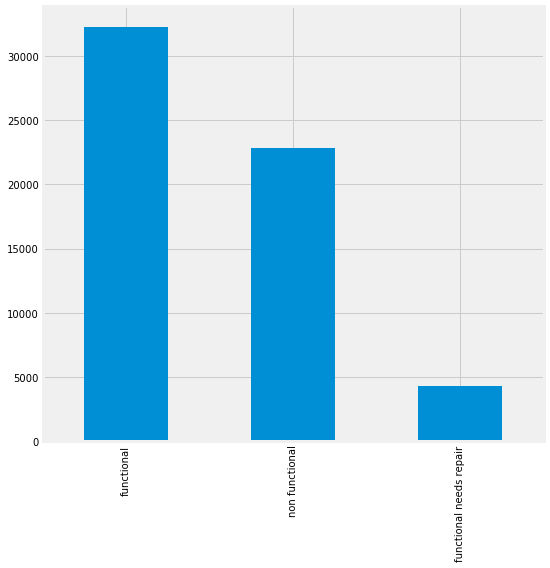

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


In [58]:
# plot the distribution of labels

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

df_labels["status_group"].value_counts().plot(kind='bar', ax=ax)
plt.show()
print(df_labels["status_group"].value_counts())


In [59]:
# pandas describe gives good summary info
df_train.describe()


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


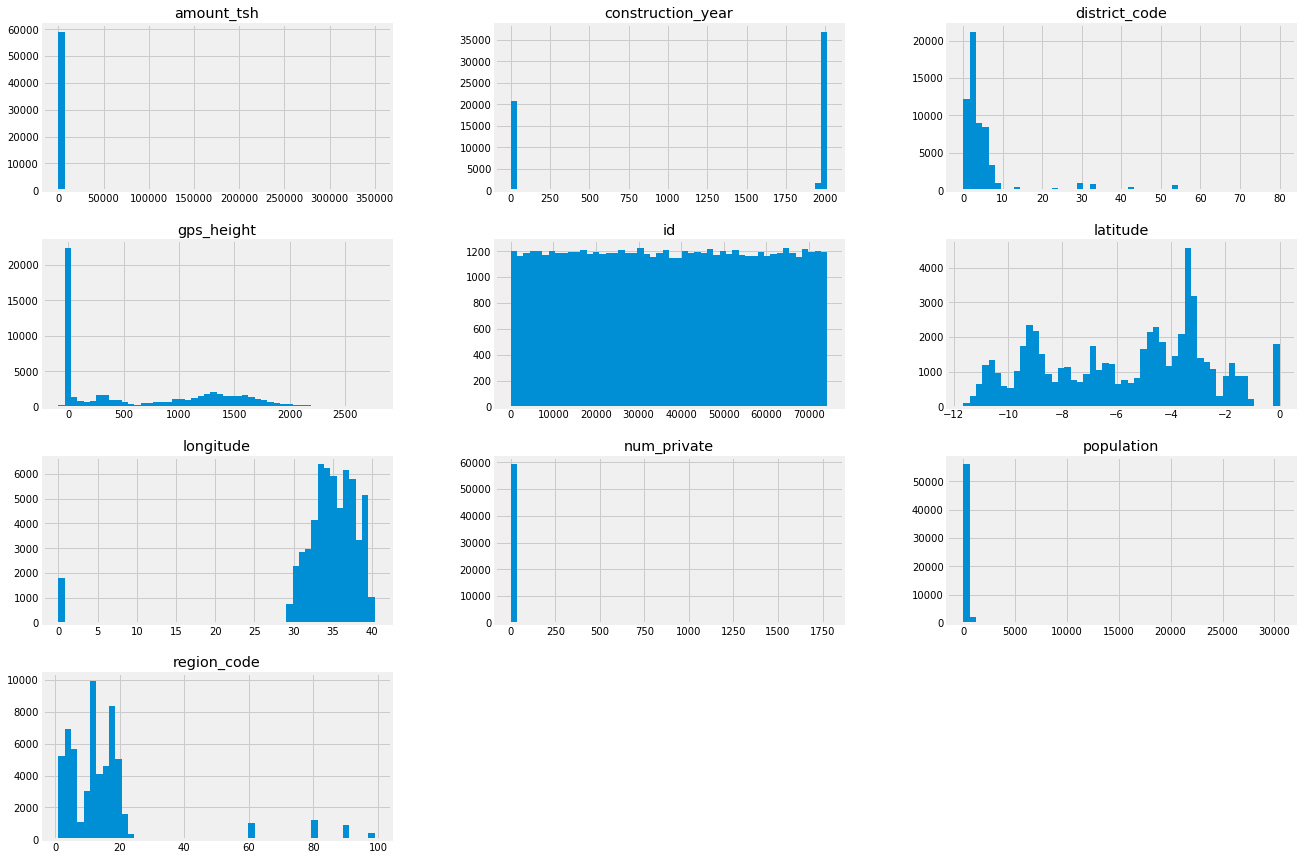

In [60]:
# plot distributions to infer more from the dataset

df_train.hist(bins=50, figsize=(20,15)) 
plt.show()

## Data exploration thoughts 

- A lot of values are zero. 
    - Possibly due to any rows without information are just set to zero. 
    - Makes me wonder what is worth keeping. 
- Are these features important?
    - Might be irrelevant if you cant get this information...
    - Could use inferences from random forests to detemine which are useful.
- Most features are 'objects' or strings.
    - Need to convert to integers or floats or arrays via one hot encoding.
- Seems like a good dataset size with many features having >50,000 non-null values but not sure how many are zero and want to get rid of.
    - Some have significantly less non-null values. 
    

/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please us

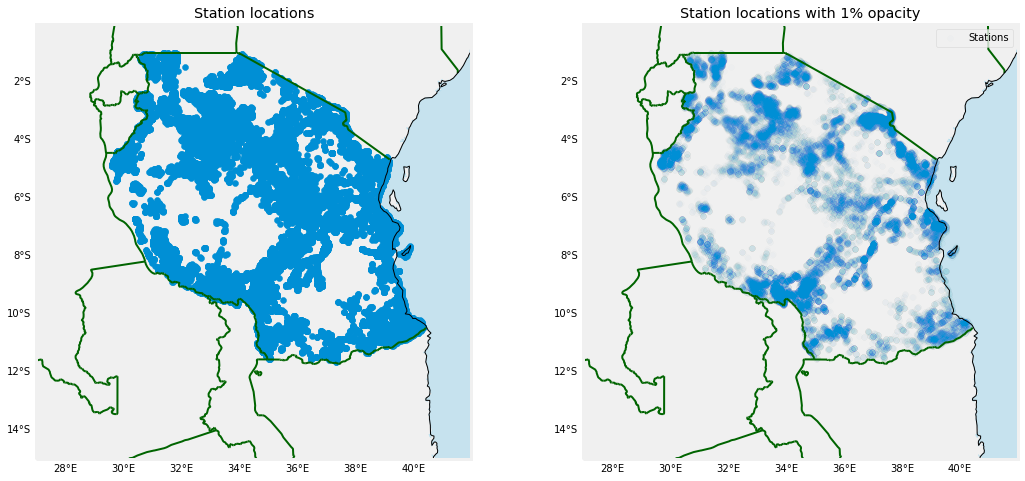

In [61]:
# plot locations of stations
df_train_labels = df_train.copy()

df_train_labels['labels'] = df_labels["status_group"].values

lons=np.array(df_train["longitude"])
lats=np.array(df_train["latitude"])

plot_stations(lons, lats)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


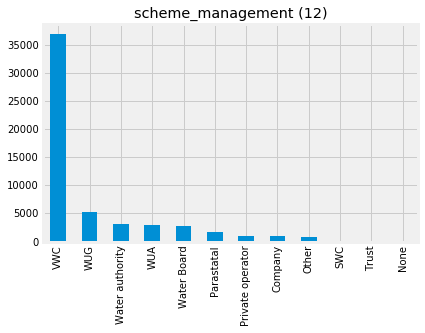

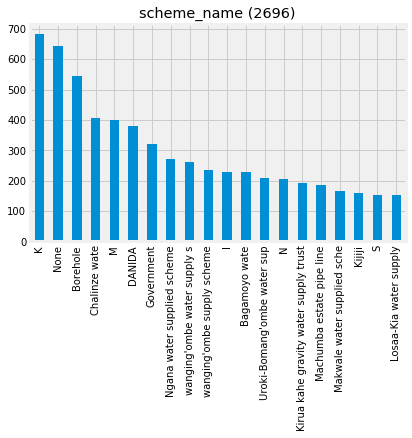

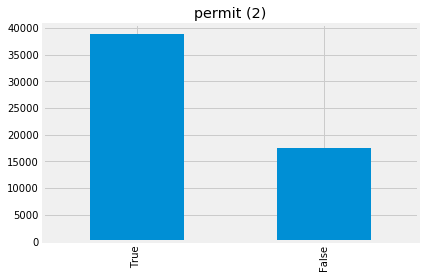

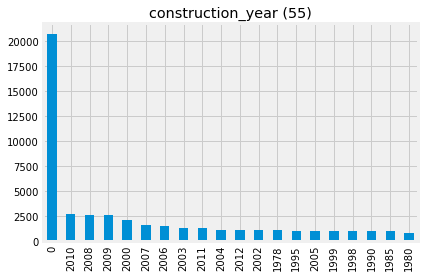

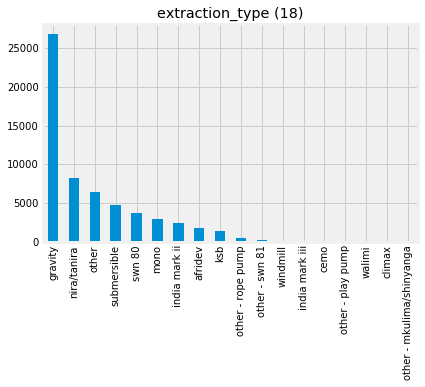

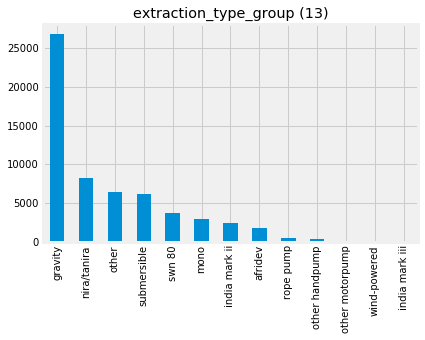

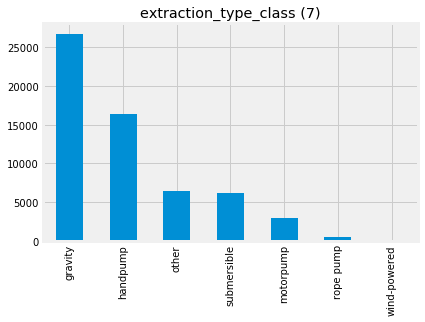

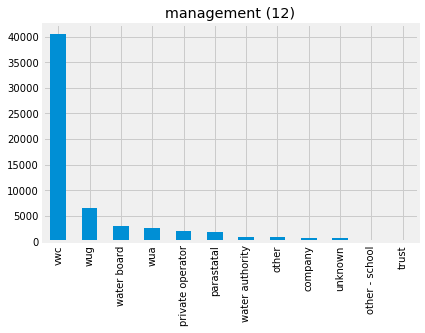

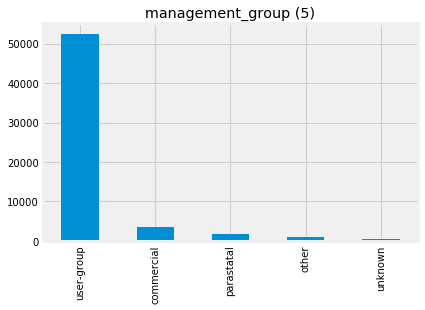

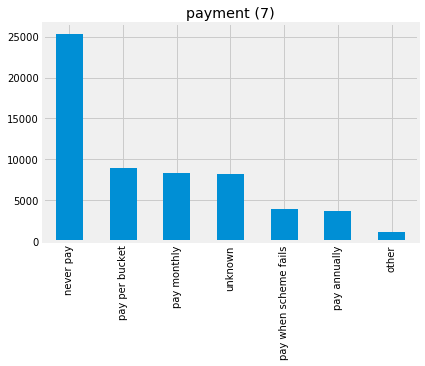

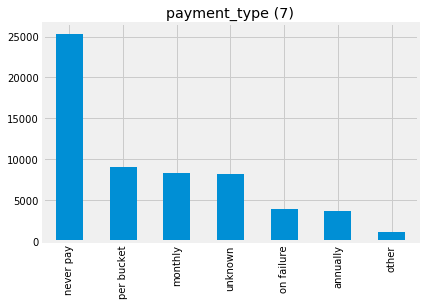

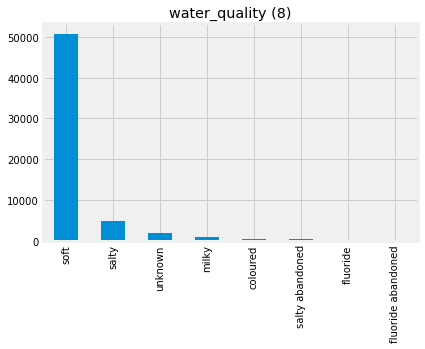

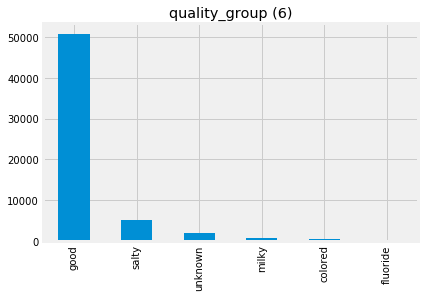

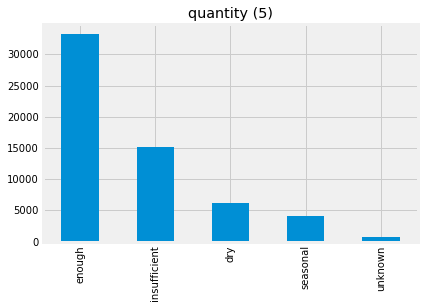

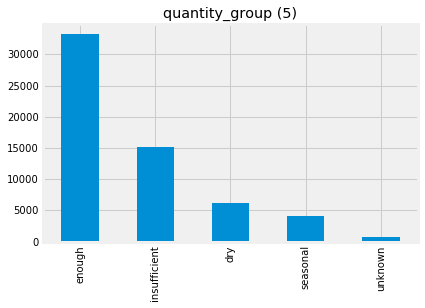

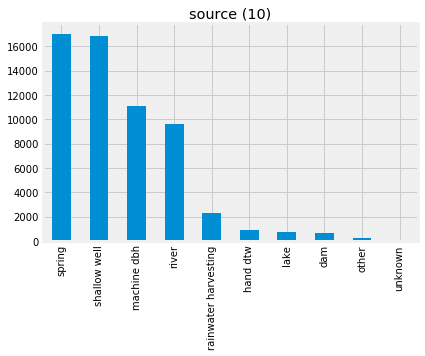

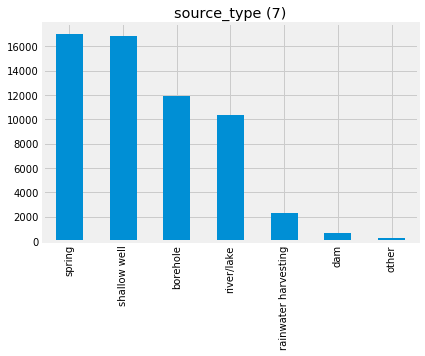

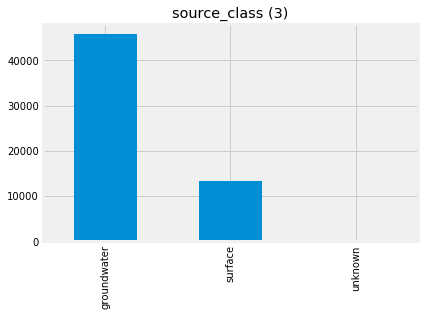

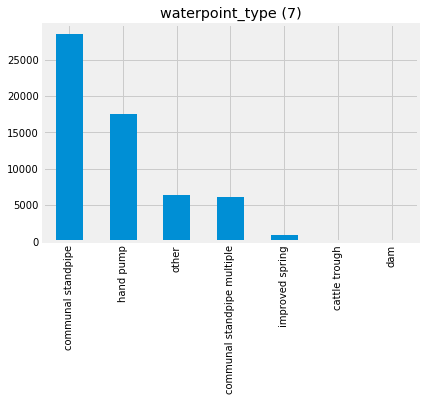

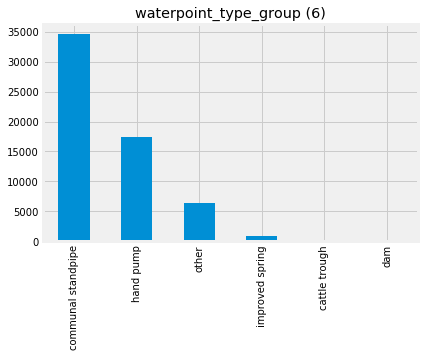

In [62]:
## counting values in some of the columns

print(df_train.keys())

for key in df_train.keys()[20:]:
    df_train[key].value_counts(sort=True).nlargest(20).plot.bar()
    plt.title(key + " (" + str(df_train[key].value_counts().shape[0]) + ")")
    plt.show()

    

## Preprocessing

### To do 

- Quantify the qualitative labels using onehot encoding. 
- Decide what/if to scale some features.
- Decide which to remove. 
    - They seem to have different columns with differing levels of detail e.g. "extraction_group", "extraction_group_type", "extraction_group_class"
    - Going to remove the ones with less detail?? 
- Decide which to combine. 

### What I have done to the dataset

- Replaces nans in scheme_management, permit with 'Unknown'
- Drop attribute called "scheme_name"
- Drop the first 20 attributes. 
- Change the construction year '0's to be the median?
    - 2000 is the median.
    - Better for feature scaling. 
    - As it turns out, construction year has a big influence on the prediction.
        - Going to remove the missing construction year ones. 

In [63]:

# attributes to be preprocessed using one hot encoding
cat_attribs = ['scheme_management', 'permit',
               'extraction_type', 'extraction_type_group', 'extraction_type_class',
               'management', 'management_group', 'payment', 'payment_type',
               'water_quality', 'quality_group', 'quantity', 'quantity_group',
               'source', 'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group']

# these were chosen by hand as those which i do not think would be useful
drop_attribs = ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
               'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
               'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
               'ward',  'public_meeting', 'recorded_by', 'scheme_name']

# numerical properties to be scaled
num_attribs = ['population','construction_year']

# drop attributes
df_train.drop(drop_attribs, axis=1, inplace=True)

# Create pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values = 0, strategy = "median")),
    ('scaler', MinMaxScaler())
    
])
    
cat_pipeline = Pipeline([
    ('hot', OneHotEncoder(sparse=False)),
])
    
full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs)
])

# convert to strings
for key in cat_attribs:
    df_train[key] = df_train[key].astype(str)
    
# convert to integers
for key in num_attribs:
    df_train[key] = df_train[key].astype(int)

# remove rows which have a construction year of zero
index_zero = df_train[ df_train['construction_year'] == 0 ].index
df_train.drop(index_zero , inplace=True)
df_labels.drop(index_zero , inplace=True)

df_prepared_fit = full_pipeline.fit(df_train)
df_prepared = full_pipeline.fit_transform(df_train)


In [64]:
feature_names = get_ct_feature_names(full_pipeline)


In [65]:
df_labels = df_labels['status_group']

df_labels

0            functional
1            functional
2            functional
3        non functional
5            functional
              ...      
59391    non functional
59394    non functional
59395        functional
59396        functional
59399        functional
Name: status_group, Length: 38691, dtype: object

## Training a linear SVM

- Going to start simple linear classification just to see if i have missed anything in the preprocessing.

/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.749476622470342
Precision: [0.72687113 0.80585154 0.        ]
Recall: [0.92489864 0.61719344 0.        ]


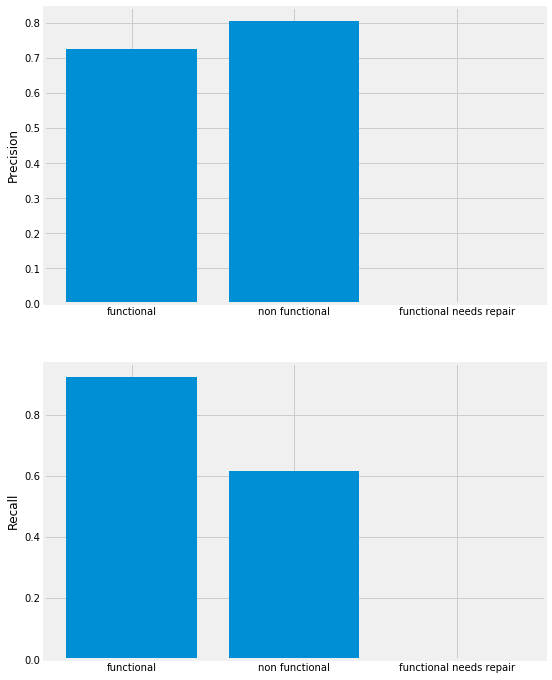

mean cross validation accuracy:  0.7487787441820394 +/- 0.0073674013522797436


In [31]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC(C=10, loss="squared_hinge", max_iter=2000, dual=False, penalty='l2')
test_classifier(svc_clf, train=df_prepared, labels=df_labels)

## Thoughts on SVM attempts

- Linear SVM seems to perform better than polynomial or rgb kernels (tested but no longer in the notebook).
- Now going to try Decision trees.  

# Decision Tree Classifier

Accuracy: 0.7730221498539712
Precision: [0.74247504 0.86146572 0.62908012]
Recall: [0.93876705 0.6300574  0.16772152]


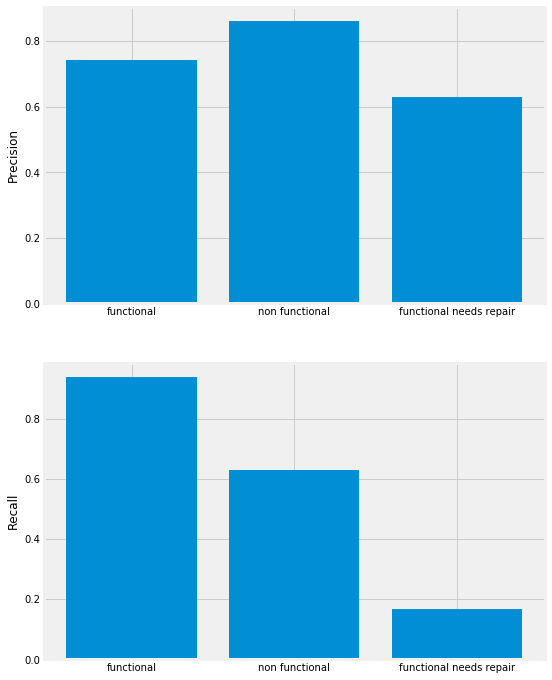

mean cross validation accuracy:  0.7575146647004647 +/- 0.005469292912195727


In [32]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=10, max_features=None) 


test_classifier(tree_clf, train=df_prepared, labels=df_labels)



In [33]:

importances = np.array(tree_clf.feature_importances_)*100
names = feature_names

# combine feature names and their importances
sorted_importances, sorted_names = (list(t) for t in zip(*sorted(zip(tree_clf.feature_importances_, feature_names), reverse=True)))

print("\nImportances!\n")
count=0
for importance, name in zip(sorted_importances, sorted_names):
    print(name, importance*100)
    count +=1
    if count > 10:
        break


Importances!

quantity_dry 29.461501791939444
waterpoint_type_group_other 18.088960223417892
construction_year 12.958095841405898
population 3.4806040903124122
waterpoint_type_communal standpipe 3.1689635313128304
waterpoint_type_communal standpipe multiple 2.557776629297896
quantity_enough 2.5302144866375693
payment_never pay 2.1992588095599874
management_company 1.9771235920340338
payment_type_never pay 1.361207837834388
payment_unknown 1.1262778987419584


## Thoughts on Decision Tree

- The importances seem to favour 'quantity_dry' (makes sense) and 'waterpoint_type_other' and 'construction_year'. 
- The recall and precision seems ok for 'functional' and 'non functional' but not great for the 'functional needs repair' labels. 
- Going to try a bunch of other models. 

# Logistic Regression

Accuracy: 0.7505104546276912
Precision: [0.73491739 0.79222915 0.44      ]
Recall: [0.91204386 0.63316965 0.03481013]


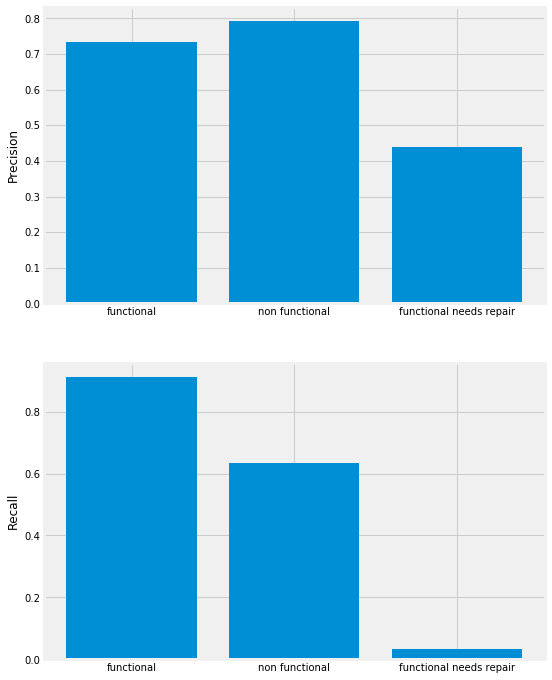

In [34]:
from sklearn.linear_model import LogisticRegression 

log_reg = LogisticRegression(C=20,max_iter=1000)

test_classifier(log_reg, train=df_prepared, labels=df_labels, cross_val=False)


# Random Forest

Accuracy: 0.7852472151146261
Precision: [0.74741469 0.89109007 0.70847458]
Recall: [0.95572245 0.63773428 0.1653481 ]


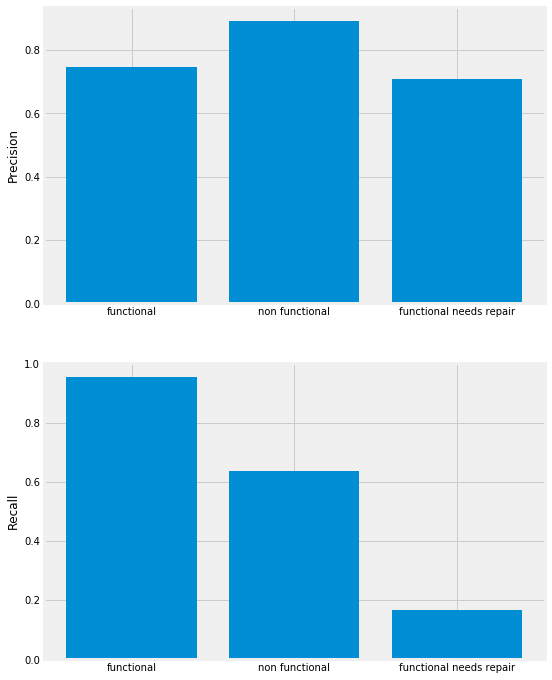

mean cross validation accuracy:  0.7702824611985684 +/- 0.005083180258611838

Importances!

0 quantity_group_dry 14.362095167474934
1 quantity_dry 14.33475184915566
2 construction_year 12.568329591460401
3 waterpoint_type_group_other 8.832919668158052
4 waterpoint_type_other 8.806134151928331
5 population 4.15593740597183
6 waterpoint_type_communal standpipe 3.0635911882267823
7 waterpoint_type_communal standpipe multiple 2.940139308616341
8 payment_type_never pay 2.0442860100175047
9 quantity_enough 1.8262753749342435
['quantity_group_dry', 'quantity_dry', 'construction_year', 'waterpoint_type_group_other', 'waterpoint_type_other', 'population', 'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 'payment_type_never pay', 'quantity_enough']


In [35]:
## Ok try the random forests now 

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=None)

test_classifier(forest_clf, train=df_prepared, labels=df_labels)

# combine feature names and their importances
sorted_importances, sorted_names = (list(t) for t in zip(*sorted(zip(forest_clf.feature_importances_, feature_names), reverse=True)))

print("\nImportances!\n")
count=0
for importance, name in zip(sorted_importances, sorted_names):
    print(count, name, importance*100)
    count +=1
    if count == 10:
        break

importances_to_keep = sorted_names[:10]
print(importances_to_keep)


# hyperparameter tuning, not worthwhile for this work

# param_grid = [
# {'n_estimators': [50,100,250,500,1000]},
# ]



# grid_search = GridSearchCV(forest_clf, param_grid, cv=5, 
#                            scoring='accuracy',
#                            return_train_score=True)


# grid_search.fit(df_prepared, df_labels)

# print(grid_search.best_params_)

# test_classifier(grid_search.best_estimator_, train=df_prepared, labels=df_labels)


# Adaptive Boosting 

Accuracy: 0.9249437853764442
Precision: [0.92122801 0.9341917  0.90422152]
Recall: [0.95535385 0.90324365 0.78797468]


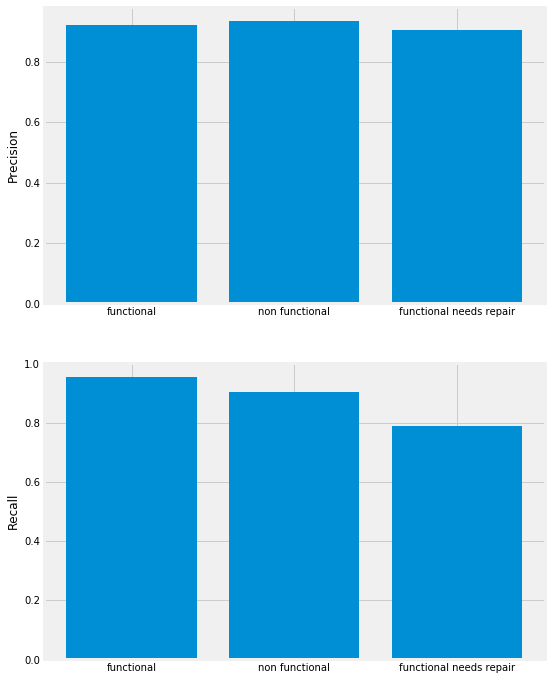

mean cross validation accuracy:  0.7577213162599687 +/- 0.00651860306905137


In [36]:
# Now for adaptive boosting classifiers with decision trees

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(tree_clf, n_estimators=10, 
                             algorithm="SAMME.R", learning_rate=0.5)

test_classifier(ada_clf, train=df_prepared, labels=df_labels)


# Neural network preparation and training

In [37]:
# data preparation for NN

df_prep_nn = df_prepared.astype(float)
enc = OneHotEncoder(sparse=False)

df_labels_nn = enc.fit_transform(np.array(df_labels).reshape(-1,1))

print(df_labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [38]:
## ok again!
# Lets try a simple NN using tensorflow!

import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[144]))
model.add(keras.layers.Dense(200, activation="relu")) 
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])

2022-04-28 09:50:11.107334: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-28 09:50:11.191500: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa1deee2a60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-28 09:50:11.191524: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [39]:
# history = model.fit(df_prepared, df_labels, validation_split=0.3, epochs=50)
# print(df_prepared.shape)

test_NN(model, train=df_prep_nn, labels=df_labels_nn, epochs=1, val_split=0.2)


Train on 30952 samples, validate on 7739 samples
30952/30952 [==============================] - 7s 212us/sample - loss: 0.6262 - accuracy: 0.7479 - val_loss: 0.5922 - val_accuracy: 0.7626
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Accuracy: 0.7655527125171229
Precision: [0.76373909 0.46280992 0.78654971]
Recall: [0.89066532 0.13291139 0.68836019]


# Using only the most 'important' features

* From the random forest analysis, the top 10 most valuable importances have been given. I am going to reduce the training dataset features to only include these features and see if it makes a difference. 

In [73]:
print('Importances from random forest: \n', importances_to_keep)
print('\n')
print("The importances actually show which value in the feature is the most useful (e.g. quantity_group_dry is a feature showing if the quantity_group value is dry)")
print("I cant think of a way to effectively automate this yet so I am going to manually choose the features from these importances")
to_keep = ['quantity', 'construction_year', 'waterpoint_type_group', 'waterpoint_type', 'population', 'payment_type']
df_train_imp = df_train.drop(columns=[col for col in df_train if col not in to_keep])

num_attribs_imp = []
cat_attribs_imp = []
for imp in to_keep:
    if imp in num_attribs:
        num_attribs_imp.append(imp)
    else:
        cat_attribs_imp.append(imp)


Importances from random forest: 
 ['quantity_group_dry', 'quantity_dry', 'construction_year', 'waterpoint_type_group_other', 'waterpoint_type_other', 'population', 'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 'payment_type_never pay', 'quantity_enough']


The importances actually show which value in the feature is the most useful (e.g. quantity_group_dry is a feature showing if the quantity_group value is dry)
I cant think of a way to effectively automate this yet so I am going to manually choose the features from these importances


In [67]:
df_train_imp

,population,construction_year,payment_type,quantity,waterpoint_type,waterpoint_type_group
0,109,1999,annually,enough,communal standpipe,communal standpipe
1,280,2010,never pay,insufficient,communal standpipe,communal standpipe
2,250,2009,per bucket,enough,communal standpipe multiple,communal standpipe
3,58,1986,never pay,dry,communal standpipe multiple,communal standpipe
5,1,2009,per bucket,enough,communal standpipe multiple,communal standpipe
...,...,...,...,...,...,...
59391,210,1967,never pay,enough,communal standpipe,communal standpipe
59394,89,2007,monthly,enough,communal standpipe,communal standpipe
59395,125,1999,per bucket,enough,communal standpipe,communal standpipe
59396,56,1996,annually,enough,communal standpipe,communal standpipe


In [68]:
# ok rerun the pipeline! 

full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs_imp),
    ("num", num_pipeline, num_attribs_imp)
])

# convert to strings
for key in cat_attribs_imp:
    df_train_imp[key] = df_train_imp[key].astype(str)
    
# convert to integers
for key in num_attribs_imp:
    df_train_imp[key] = df_train_imp[key].astype(int)

df_prepared_fit = full_pipeline.fit(df_train_imp)
df_prepared = full_pipeline.fit_transform(df_train_imp)



Linear SVM


/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7246646506939598
Precision: [0.70356189 0.78342952 0.        ]
Recall: [0.92282529 0.55391106 0.        ]


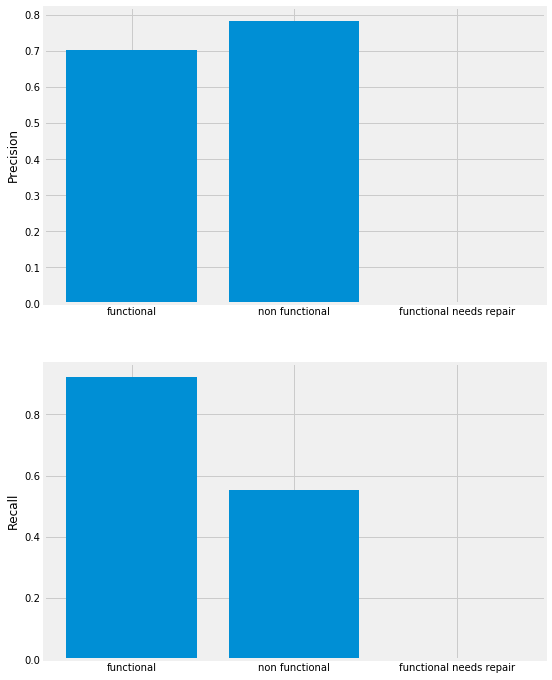

mean cross validation accuracy:  0.7245354213542616 +/- 0.00825937674811914
Decision Tree
Accuracy: 0.7592980279651599
Precision: [0.75027035 0.78953469 0.57697642]
Recall: [0.89504239 0.65952002 0.16455696]


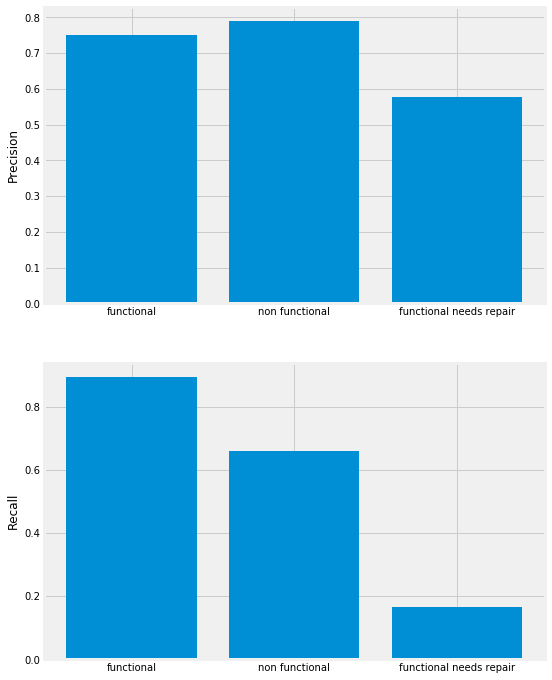

mean cross validation accuracy:  0.744359217873737 +/- 0.006899531028388193
Random Forest
Accuracy: 0.7682406761262309
Precision: [0.7492471  0.81811105 0.64070796]
Recall: [0.9170199  0.65419462 0.1431962 ]


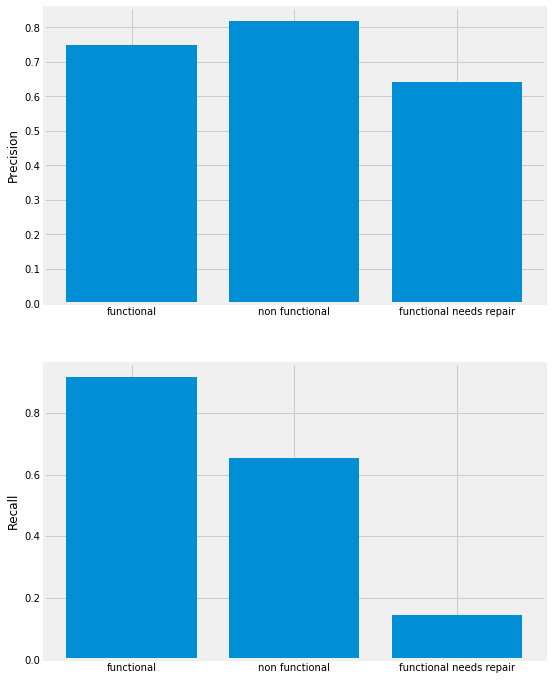

mean cross validation accuracy:  0.7543357289740287 +/- 0.007485365276788728


In [70]:
# try out a couple of the models again 

# linear svm
print('Linear SVM')
svc_clf = LinearSVC(C=10, loss="squared_hinge", max_iter=2000, dual=False, penalty='l2')
test_classifier(svc_clf, train=df_prepared, labels=df_labels)

print('Decision Tree')
tree_clf = DecisionTreeClassifier(max_depth=10, max_features=None) 
test_classifier(tree_clf, train=df_prepared, labels=df_labels)

print('Random Forest')
forest_clf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=None)
test_classifier(forest_clf, train=df_prepared, labels=df_labels)

In [76]:
# try NN again 

# data preparation for NN
df_prep_nn = df_prepared.astype(float)
enc = OneHotEncoder(sparse=False)

df_labels_nn = enc.fit_transform(np.array(df_labels).reshape(-1,1))

print(df_labels_nn)


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(38691, 27)


In [77]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[df_prep_nn.shape[1]]))
model.add(keras.layers.Dense(200, activation="relu")) 
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])

In [78]:
test_NN(model, train=df_prep_nn, labels=df_labels_nn, epochs=10, val_split=0.2)


Train on 30952 samples, validate on 7739 samples
Epoch 1/10
30952/30952 [==============================] - 3s 112us/sample - loss: 0.6766 - accuracy: 0.7192 - val_loss: 0.6483 - val_accuracy: 0.7389
Epoch 2/10
30952/30952 [==============================] - 3s 90us/sample - loss: 0.6613 - accuracy: 0.7242 - val_loss: 0.6436 - val_accuracy: 0.7398
Epoch 3/10
30952/30952 [==============================] - 3s 82us/sample - loss: 0.6577 - accuracy: 0.7262 - val_loss: 0.6459 - val_accuracy: 0.7420
Epoch 4/10
30952/30952 [==============================] - 2s 80us/sample - loss: 0.6567 - accuracy: 0.7276 - val_loss: 0.6448 - val_accuracy: 0.7414
Epoch 5/10
30952/30952 [==============================] - 3s 102us/sample - loss: 0.6556 - accuracy: 0.7289 - val_loss: 0.6423 - val_accuracy: 0.7427
Epoch 6/10
30952/30952 [==============================] - 3s 90us/sample - loss: 0.6532 - accuracy: 0.7299 - val_loss: 0.6433 - val_accuracy: 0.7401
Epoch 7/10
30952/30952 [==============================]

## Concluding thoughts 

In this notebook I have managed to predict the functionality of water pumps using a variety of statistical tools in a relatively simple task. This exercise aimed to familiarise myself with the tools to complete a data science project and see if using random forests importances could improve training. 

The random forest, adaptive boosting and neural network seem to have a slightly higher accuracy but possibly not so much better it is worth the training time. Using the inferences to reduce the number of features did make things a bit quicker but also slightly reduced the precision recall and accuracy. This is probably because of the severity with which I cut down the number of features. Still, using a fraction of the informaion (40 features to 6 features) and maintaining very similar performance is worthwhile as less data needs to be collected increasing the efficiency of the whole process. 

After gaining a little more experience there are some directions I would take this work in to (potentially) improve it:

* Move the "functional needs repair" labels to be "non functional" or remove them all together. The logic for this is this may simplify the task for the statistical models and I believe the "non functional" water pumps need repair also. 
* Combine all the statistical models trained into an ensemble and use that to predict the classification. 
    * Multilabel/multi-output classification is not supported apparently :(.
* Would be interesting to see the different confusion matrices for the different statistical models to see if they are getting confused in a similar way. 
* Possibly all of the above...

Anyway, I hope this showcased some foundation data analysis skills and you (may) have gotten something out of this also!